In [1]:
"""Imports """

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

# To import from the GAUCHE package
import sys
sys.path.append('..')

from botorch import fit_gpytorch_model
from botorch.acquisition import GenericMCObjective, LearnedObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement, qSimpleRegret

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.deterministic import FixedSingleSampleModel
from botorch.models import SingleTaskGP
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from botorch.sampling import SobolQMCNormalSampler

import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
import torch
import time
from itertools import combinations

from gauche.dataloader import DataLoaderMP
from gauche.dataloader.data_utils import transform_data
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption
from mordred import Calculator, descriptors
from rdkit import Chem

To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To use the Graphein submodule graphein.protein.visualisation, you need to install: pytorch3d 
To do so, use the following command: conda install -c pytorch3d pytorch3d


[05/23/23 20:23:13] WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=369135;file:///Users/ryanrhys/opt/miniconda3/envs/gauche/lib/python3.7/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=994595;file:///Users/ryanrhys/opt/miniconda3/envs/gauche/lib/python3.7/site-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

In [2]:
# Generate ground truth preference data

def generate_initial_comparisons(y, n_comp, replace=False):
    """Create pairwise comparisons with noise assuming y is 1d"""
    # generate all possible pairs of elements in y
    all_pairs = np.array(list(combinations(range(y.shape[0]), 2)))
    # randomly select n_comp pairs from all_pairs
    comp_pairs = all_pairs[np.random.choice(range(len(all_pairs)), n_comp, replace=replace)]
    c0 = y[comp_pairs[:, 0]]
    c1 = y[comp_pairs[:, 1]]
    reverse_comp = (c0 < c1)
    comp_pairs[reverse_comp, :] = np.flip(comp_pairs[reverse_comp, :], 1)
    comp_pairs = torch.tensor(comp_pairs).long()

    return comp_pairs

def generate_comparisons(util):
    """Given an 1-d tensor of utility, create pairwise comparisons between adjacent items"""
    util = util.reshape(-1, 2)
    comp_pairs = torch.arange(util.numel()).reshape(-1, 2)
    flip = util[:, 0] < util[:, 1]
    comp_pairs[flip, [0]], comp_pairs[flip, [1]] = comp_pairs[flip, [1]], comp_pairs[flip, [0]]

    return comp_pairs


In [3]:
def update_random_observations(best_random, heldout_inputs, heldout_outputs):
    """
    Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point from the heldout set, observing its value, and updating the list.

    Args:
        best_random: List of best random values observed so far
        heldout_inputs: Tensor of inputs
        heldout_outputs: Tensor of output values

    Returns: best_random, float specifying the objective function value.
    """

    # Take a random sample by permuting the indices and selecting the first element.
    index = torch.randperm(len(heldout_outputs))[0]
    next_random_best = heldout_outputs[index]
    best_random.append(max(best_random[-1], next_random_best))

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:index], heldout_inputs[index+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:index], heldout_outputs[index+1:]), axis=0)

    return best_random, heldout_inputs, heldout_outputs

In [4]:
"""Mordred descriptor computation is expensive"""

# Load the Photoswitch dataset
loader = DataLoaderMP()
loader.load_benchmark("Photoswitch", "../data/property_prediction/photoswitches.csv")
y = loader.labels

calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in loader.features]
t0 = time.time()
X = [calc(mol) for mol in mols]
t1 = time.time()
print(f'Mordred descriptor computation takes {t1 - t0} seconds')
X = np.array(X).astype(np.float64)

Mordred descriptor computation takes 548.5526521205902 seconds


In [5]:
"""Fragprint descriptor computation"""

loader.featurize('fragprints')
X_frag = loader.features

In [6]:
"""Collect nan indices"""

nan_dims = []

for i in range(len(X)):
    nan_indices = list(np.where(np.isnan(X[i, :]))[0])
    for dim in nan_indices:
        if dim not in nan_dims:
            nan_dims.append(dim)
            
X_mordred_nonan = np.delete(X, nan_dims, axis=1)

# Remove variables with near-constant variance
variance_threshold = 0.05
selector = VarianceThreshold(variance_threshold)
X_rem = selector.fit_transform(X_mordred_nonan)

# Store values for BayesOpt
y_bo = X_rem

In [10]:
"""BOPE specific utilities"""

def fit_outcome_model(X, Y):
    """Fit the outcome model f"""
    outcome_model = SingleTaskGP(
        train_X=X,
        train_Y=Y,
        outcome_transform=Standardize(m=Y.shape[-1]),
        covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel()),
    )
    mll = ExactMarginalLogLikelihood(outcome_model.likelihood, outcome_model)
    fit_gpytorch_model(mll)
    return outcome_model


def fit_pref_model(Y, comps):
    """Fit the preference model g"""
    model = PairwiseGP(Y, comps)
    mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model


def run_pref_learn(outcome_model, train_Y, train_comps, n_comps, heldout_inputs, heldout_outputs, previous_winner,
                  previous_winner_util):
    """Perform preference exploration for n_comps rounds"""
    
    for i in range(n_comps):
        
        pref_model = fit_pref_model(train_Y, train_comps)
        
        # EUBO-zeta
        one_sample_outcome_model = FixedSingleSampleModel(model=outcome_model)
        
        acqf = AnalyticExpectedUtilityOfBestOption(
            pref_model=pref_model, 
            outcome_model=one_sample_outcome_model, 
            previous_winner=previous_winner
        )
        
        # Loop over the discrete set of points to evaluate the acquisition function at.
        acq_vals = []
        for i in range(len(heldout_outputs)):
            acq_vals.append(acqf(heldout_inputs[i].unsqueeze(-2)))  # use unsqueeze to append batch dimension

        # observe new values
        acq_vals = torch.tensor(acq_vals)
        best_idx = torch.argmax(acq_vals)
        cand_X = heldout_inputs[best_idx].unsqueeze(-2)  # add batch dimension
        new_util = heldout_outputs[best_idx].unsqueeze(-1)
        
        cand_Y = one_sample_outcome_model(cand_X)
        cand_Y = cand_Y.detach().clone()
        cand_comps = generate_comparisons(torch.cat((previous_winner_util, new_util)).squeeze(-1))

        train_comps = torch.cat((train_comps, cand_comps))
        train_Y = torch.cat((train_Y, cand_Y))

    return train_Y, train_comps


def gen_exp_cand(outcome_model, objective, q, heldout_inputs, heldout_outputs, heldout_ys):
    """Given an outcome model and an objective, generate q experimental candidates
    using specified acquisition function."""
    # generate experimental candidates with qNEI/qNEIUU
    acq_func = qNoisyExpectedImprovement(
        model=outcome_model,
        objective=objective,
        X_baseline=outcome_model.train_inputs[0][0, :], # TODO: Improve me
        prune_baseline=True,
    )
    
    # Loop over the discrete set of points to evaluate the acquisition function at.
    acq_vals = []
    for i in range(len(heldout_outputs)):
        acq_vals.append(acq_func(heldout_inputs[i].unsqueeze(-2)))  # use unsqueeze to append batch dimension

    # observe new values
    acq_vals = torch.tensor(acq_vals)
    best_idx = torch.argmax(acq_vals)
    cand_X = heldout_inputs[best_idx].unsqueeze(-2)  # add batch dimension
    new_util = heldout_outputs[best_idx].unsqueeze(-1)  # add output dimension
    new_y = heldout_ys[best_idx].unsqueeze(-2)  # add batch dimension

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:best_idx], heldout_inputs[best_idx+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:best_idx], heldout_outputs[best_idx+1:]), axis=0)
    heldout_ys = torch.cat((heldout_ys[:best_idx], heldout_ys[best_idx+1:]), axis=0)

    return cand_X, new_util, heldout_inputs, heldout_outputs, new_y, heldout_ys

In [19]:
"""Bayesian optimisation loop"""

N_TRIALS = 15
holdout_set_size = 0.75
n_components = 5
N_ITERS = 20
m = 500 # Initial comparisons
n_comps = 1 # comparisons per iteration
NUM_OUTCOME_SAMPLES = 64

best_observed_all_eubo, best_random_all = [], []

# average over multiple random trials (each trial splits the initial training set for the GP in a random manner)
for trial in range(1, N_TRIALS + 1):
    
    # Experimentation stage: initial exploration batch
    torch.manual_seed(trial+20)
    np.random.seed(trial+20)

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_eubo, best_random = [], []
    
    # Generate initial outcome data and initialize model
    train_x_eubo, heldout_x_eubo, train_y_eubo, heldout_y_eubo = train_test_split(X_frag, y_bo, test_size=holdout_set_size, random_state=trial)
    # Generate the true utility values using the same split
    _, _, train_utils, heldout_utils = train_test_split(X_frag, y, test_size=holdout_set_size, random_state=trial)
    
    # Apply PCA to the outcomes
    scaler = StandardScaler()
    train_y_eubo_pca = scaler.fit_transform(train_y_eubo)
    heldout_y_eubo_pca = scaler.transform(heldout_y_eubo)
    pca_mordred = PCA(n_components=n_components)
    train_y_eubo_pca = pca_mordred.fit_transform(train_y_eubo_pca)
    heldout_y_eubo_pca = pca_mordred.transform(heldout_y_eubo_pca)    
    best_observed_value_eubo = torch.tensor(np.max(train_utils))
    
    # Set the previous winner for the first round
    previous_winner = torch.tensor(train_y_eubo_pca[np.argmax(train_utils)]).unsqueeze(-2)
    previous_winner_util = torch.tensor(np.max(train_utils)).unsqueeze(-1).unsqueeze(-1)

    # Convert numpy arrays to PyTorch tensors and flatten the label vectors
    train_x_eubo = torch.tensor(train_x_eubo.astype(np.float64))
    heldout_x_eubo = torch.tensor(heldout_x_eubo.astype(np.float64))
    train_y_eubo_pca = torch.tensor(train_y_eubo_pca.astype(np.float64))
    heldout_y_eubo_pca = torch.tensor(heldout_y_eubo_pca.astype(np.float64))
    train_utils = torch.tensor(train_utils)
    heldout_utils = torch.tensor(heldout_utils)
    train_comps = generate_initial_comparisons(train_utils.squeeze(-1), m)
    train_y_eubo = torch.tensor(train_y_eubo)
    heldout_y_eubo = torch.tensor(heldout_y_eubo)

    # The initial heldout set is the same for random search
    heldout_x_random = heldout_x_eubo
    heldout_utils_random = heldout_utils
    
    # Initialize the outcome model
    outcome_model = fit_outcome_model(train_x_eubo, train_y_eubo_pca)

    best_observed_eubo.append(best_observed_value_eubo)
    best_random.append(best_observed_value_eubo)

    # run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ITERS + 1):
                                                    
        # Run preference exploration
        _, train_comps = run_pref_learn(outcome_model, train_y_eubo_pca, train_comps, n_comps, 
                                              heldout_x_eubo, heldout_utils, previous_winner,
                                              previous_winner_util)
                        
        # Run experimentation with the learned preference model and qNEIUU
        pref_model = fit_pref_model(train_y_eubo_pca, train_comps)
        pref_obj = LearnedObjective(pref_model=pref_model)
        new_x_eubo, new_util, heldout_x_eubo, heldout_utils, new_y_eubo, heldout_y_eubo = gen_exp_cand(outcome_model, pref_obj, q=1, 
                                                                           heldout_inputs=heldout_x_eubo, 
                                                                           heldout_outputs=heldout_utils,
                                                                           heldout_ys=heldout_y_eubo)
                        
        # update training points
        train_x_eubo = torch.cat([train_x_eubo, new_x_eubo])
        train_y_eubo = torch.cat([train_y_eubo, new_y_eubo])
        
        # Re-apply PCA to the outcomes
        scaler = StandardScaler()
        train_y_eubo_pca = scaler.fit_transform(train_y_eubo)
        heldout_y_eubo_pca = scaler.transform(heldout_y_eubo)
        pca_mordred = PCA(n_components=n_components)
        train_y_eubo_pca = torch.tensor(pca_mordred.fit_transform(train_y_eubo_pca))
        heldout_y_eubo_pca = torch.tensor(pca_mordred.transform(heldout_y_eubo_pca))    
        
        # update previous winners
        previous_winner = torch.tensor(pca_mordred.transform(scaler.transform(new_y_eubo)))
        previous_winner_util = new_util
        
        # update random search progress
        best_random, heldout_x_random, heldout_utils_random = update_random_observations(best_random,
                                                                                     heldout_inputs=heldout_x_random,
                                                                                     heldout_outputs=heldout_utils_random)
        best_value_eubo = torch.max(new_util, best_observed_eubo[-1])
        best_observed_eubo.append(best_value_eubo)
        
        # reinitialise the outcome model so it is ready for fitting on the next iteration
        outcome_model = fit_outcome_model(train_x_eubo, train_y_eubo_pca)
        
        print(".", end="")

    best_observed_all_eubo.append(best_observed_eubo)
    best_random_all.append(best_random)



Trial  1 of 15 ....................
Trial  2 of 15 ....................
Trial  3 of 15 ....................
Trial  4 of 15 ....................
Trial  5 of 15 ....................
Trial  6 of 15 ....................
Trial  7 of 15 ....................
Trial  8 of 15 ....................
Trial  9 of 15 ....................
Trial 10 of 15 ....................
Trial 11 of 15 ....................
Trial 12 of 15 ....................
Trial 13 of 15 ....................
Trial 14 of 15 ....................
Trial 15 of 15 ....................

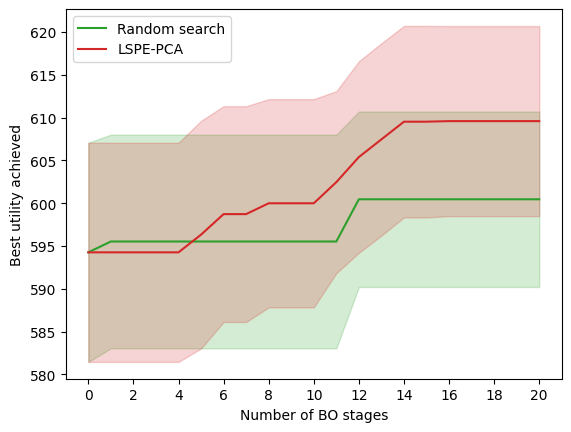

623.0


In [20]:
"""Plots the results"""

# Define a confidence interval function for plotting.
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_ITERS + 1)
y_eubo = np.asarray(best_observed_all_eubo)
y_rnd = np.asarray(best_random_all)

y_rnd_mean = y_rnd.mean(axis=0)
y_eubo_mean = y_eubo.mean(axis=0)
y_rnd_std = y_rnd.std(axis=0)
y_eubo_std = y_eubo.std(axis=0)

lower_rnd = y_rnd_mean - ci(y_rnd)
upper_rnd = y_rnd_mean + ci(y_rnd)
lower_eubo = y_eubo_mean - ci(y_eubo)
upper_eubo = y_eubo_mean + ci(y_eubo)

plt.plot(iters, y_rnd_mean, label='Random search', color='tab:green')
plt.fill_between(iters, lower_rnd, upper_rnd, alpha=0.2, color='tab:green')
plt.plot(iters, y_eubo_mean, label='LSPE-PCA', color='tab:red')
plt.fill_between(iters, lower_eubo, upper_eubo, alpha=0.2, color='tab:red')
plt.xlabel('Number of BO stages')
plt.ylabel('Best utility achieved')
plt.legend(loc="upper left")
plt.xticks(list(np.arange(0, 21, 2)))
plt.show()

print(np.max(y_eubo))


In [18]:
np.savetxt('y_eubo_new1.txt', y_eubo)
np.savetxt('y_rnd_new1.txt', y_rnd)